In [1]:
#import sys
import numpy as np
from scipy import linalg
from sklearn.preprocessing import OneHotEncoder
import emachine as EM
#from direct_info import direct_info,frequency

from data_processing import data_processing
import Bio.PDB, warnings
pdb_list = Bio.PDB.PDBList()
pdb_parser = Bio.PDB.PDBParser()
from scipy.spatial import distance_matrix
from Bio import BiopythonWarning
warnings.simplefilter('ignore', BiopythonWarning)

#data_path = '../protein/Pfam-A.full'
data_path = '../'

from scipy.sparse import csr_matrix
import timeit
from joblib import Parallel, delayed

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
np.random.seed(1)
pfam_id = 'PF00186'
#pfam_id = sys.argv[1]

ipdb = 0

ext_name = '%s/%02d'%(pfam_id,ipdb)

#--------------------------------------------
# read data
pdb = np.load('%s/%s/pdb_refs.npy'%(data_path,pfam_id))
npdb = pdb.shape[0]

pdb = np.array([pdb[t,i].decode('UTF-8') for t in range(pdb.shape[0]) \
         for i in range(pdb.shape[1])]).reshape(pdb.shape[0],pdb.shape[1])

tpdb = int(pdb[ipdb,1])

In [3]:
# data processing
s0,cols_removed = data_processing(data_path,pfam_id,ipdb,\
                  gap_seqs=0.2,gap_cols=0.2,prob_low=0.004,conserved_cols=0.9)

In [4]:
# inferring h0 and w
l,n_var = s0.shape

#m = 21
mx = np.array([len(np.unique(s0[:,i])) for i in range(n_var)])
#mx = np.array([m for i in range(n_var)])
mx_cumsum = np.insert(mx.cumsum(),0,0)
i1i2 = np.stack([mx_cumsum[:-1],mx_cumsum[1:]]).T 

mx_sum = mx.sum()
#my_sum = mx.sum() #!!!! my_sum = mx_sum
#n_linear = n_var*(m-1)
n_linear = mx_sum - n_var

In [5]:
onehot_encoder = OneHotEncoder(sparse=False,categories='auto')
#onehot_encoder = OneHotEncoder(sparse=False,categories=mx)
seqs_onehot = onehot_encoder.fit_transform(s0)

print('compute ops')
ops,cov = EM.operators(seqs_onehot,n_var,i1i2,mx)

ops = csr_matrix(ops)
print(ops.shape)

compute ops
1565 1436281 1437846
(6734, 1437846)


In [6]:
# Lasso
l1 = 0.001
print('l1:',l1)

start_time = timeit.default_timer()
eps_list = np.linspace(0.1,1.,19)
n_eps = len(eps_list)
res = Parallel(n_jobs = n_eps)(delayed(EM.fit)\
        (ops,cov,n_var,mx,l1=l1,eps=eps,max_iter=100)\
        for eps in eps_list)

run_time = timeit.default_timer() - start_time
print('run time:',run_time)

w_eps1 = np.array([res[i][0] for i in range(len(res))])
e_eps1 = np.array([res[i][1] for i in range(len(res))])

l1: 0.001
run time: 449.26619653997477


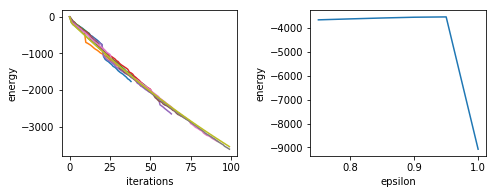

In [12]:
nx,ny = 2,1
nfig = nx*ny
fig, ax = plt.subplots(ny,nx,figsize=(nx*3.5,ny*2.8))
for i in range(9):
    ax[0].plot(e_eps1[int(2*i)])

ax[1].plot(eps_list,e_eps1[:,-1])
ax[0].set_ylabel('energy')
ax[0].set_xlabel('iterations')
ax[1].set_ylabel('energy')
ax[1].set_xlabel('epsilon')

plt.tight_layout(h_pad=1, w_pad=1.5)
plt.show()

In [10]:
eps_list

array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [11]:
e_eps1[:,-1]

array([           nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan, -3660.45987231, -3620.39495731, -3582.72280451,
       -3550.8459526 , -3537.81853758, -9073.23233371])

In [13]:
# Lasso
l1 = 0.01
print('l1:',l1)

start_time = timeit.default_timer()
eps_list = np.linspace(0.1,1.,19)
n_eps = len(eps_list)
res = Parallel(n_jobs = n_eps)(delayed(EM.fit)\
        (ops,cov,n_var,mx,l1=l1,eps=eps,max_iter=100)\
        for eps in eps_list)

run_time = timeit.default_timer() - start_time
print('run time:',run_time)

w_eps2 = np.array([res[i][0] for i in range(len(res))])
e_eps2 = np.array([res[i][1] for i in range(len(res))])

l1: 0.01
run time: 449.3723412899999


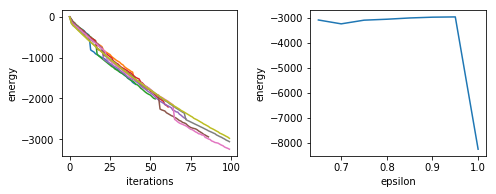

In [14]:
nx,ny = 2,1
nfig = nx*ny
fig, ax = plt.subplots(ny,nx,figsize=(nx*3.5,ny*2.8))
for i in range(9):
    ax[0].plot(e_eps2[int(2*i)])

ax[1].plot(eps_list,e_eps2[:,-1])
ax[0].set_ylabel('energy')
ax[0].set_xlabel('iterations')
ax[1].set_ylabel('energy')
ax[1].set_xlabel('epsilon')

plt.tight_layout(h_pad=1, w_pad=1.5)
plt.show()

In [28]:
e_eps2[:,-1]

array([           nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan, -3093.23481247,
       -3247.29018139, -3100.705519  , -3062.89989104, -3012.47889631,
       -2981.36647603, -2970.59462018, -8247.78253389])

In [29]:
ieps = 11 + np.argmax(e_eps2[11:,-1])
print('eps_opt:',eps_list[ieps])
w2 = w_eps2[ieps]
np.savetxt('w2.txt',w2,fmt='%f')

eps_opt: 0.9500000000000001


In [15]:
# Lasso
l1 = 0.05
print('l1:',l1)

start_time = timeit.default_timer()
eps_list = np.linspace(0.1,1.,19)
n_eps = len(eps_list)
res = Parallel(n_jobs = n_eps)(delayed(EM.fit)\
        (ops,cov,n_var,mx,l1=l1,eps=eps,max_iter=100)\
        for eps in eps_list)

run_time = timeit.default_timer() - start_time
print('run time:',run_time)

w_eps3 = np.array([res[i][0] for i in range(len(res))])
e_eps3 = np.array([res[i][1] for i in range(len(res))])

l1: 0.05
run time: 446.953672996955


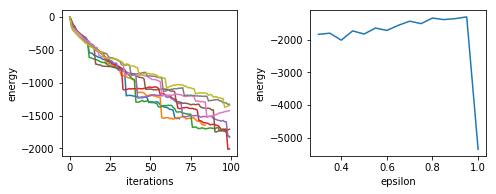

In [16]:
nx,ny = 2,1
nfig = nx*ny
fig, ax = plt.subplots(ny,nx,figsize=(nx*3.5,ny*2.8))
for i in range(9):
    ax[0].plot(e_eps3[int(2*i)])

ax[1].plot(eps_list,e_eps3[:,-1])
ax[0].set_ylabel('energy')
ax[0].set_xlabel('iterations')
ax[1].set_ylabel('energy')
ax[1].set_xlabel('epsilon')

plt.tight_layout(h_pad=1, w_pad=1.5)
plt.show()

In [19]:
e_eps3[:,-1]

array([           nan,            nan,            nan,            nan,
       -1829.48416534, -1793.65522163, -2008.35889214, -1722.98590533,
       -1819.64899005, -1635.88060886, -1708.46576666, -1552.55788061,
       -1425.38569404, -1500.44072337, -1328.90781397, -1376.85355006,
       -1346.36346732, -1294.01734352, -5355.86554417])

In [21]:
ieps = 4 + np.argmax(e_eps3[4:,-1])
print('eps_opt:',eps_list[ieps])
w3 = w_eps3[ieps]
np.savetxt('w3.txt',w3,fmt='%f')

eps_opt: 0.9500000000000001


In [22]:
# Lasso
l1 = 0.1
print('l1:',l1)

start_time = timeit.default_timer()
eps_list = np.linspace(0.1,1.,19)
n_eps = len(eps_list)
res = Parallel(n_jobs = n_eps)(delayed(EM.fit)\
        (ops,cov,n_var,mx,l1=l1,eps=eps,max_iter=100)\
        for eps in eps_list)

run_time = timeit.default_timer() - start_time
print('run time:',run_time)

w_eps4 = np.array([res[i][0] for i in range(len(res))])
e_eps4 = np.array([res[i][1] for i in range(len(res))])

l1: 0.1
run time: 450.25729929399677


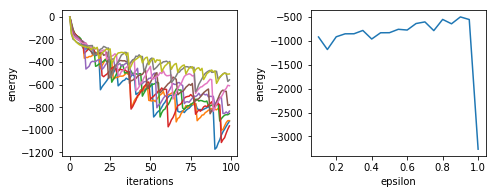

In [23]:
nx,ny = 2,1
nfig = nx*ny
fig, ax = plt.subplots(ny,nx,figsize=(nx*3.5,ny*2.8))
for i in range(9):
    ax[0].plot(e_eps4[int(2*i)])

ax[1].plot(eps_list,e_eps4[:,-1])
ax[0].set_ylabel('energy')
ax[0].set_xlabel('iterations')
ax[1].set_ylabel('energy')
ax[1].set_xlabel('epsilon')

plt.tight_layout(h_pad=1, w_pad=1.5)
plt.show()

In [24]:
e_eps4[:,-1]

array([ -924.29933367, -1185.92107793,  -920.31935229,  -858.50163175,
        -857.45030634,  -788.4959327 ,  -966.87295851,  -836.54712145,
        -835.35071243,  -764.07467525,  -779.65740175,  -643.89215438,
        -610.08398387,  -791.58137941,  -558.16431854,  -649.34656293,
        -505.80135192,  -560.32097995, -3265.15443007])

In [26]:
ieps = np.argmax(e_eps4[:,-1])
print('eps_opt:',eps_list[ieps])
w4 = w_eps4[ieps]
np.savetxt('w4.txt',w4,fmt='%f')

eps_opt: 0.9


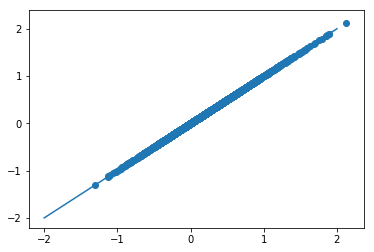

In [30]:
plt.plot([-2,2],[-2,2])
plt.scatter(w3,w4)

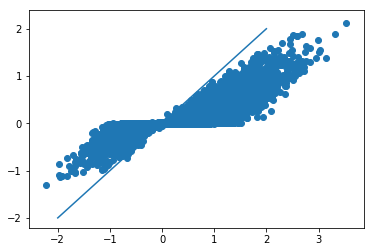

In [31]:
plt.plot([-2,2],[-2,2])
plt.scatter(w2,w3)

In [32]:
def ij_2d_from_1d(n_var,i1i2,mx):
    mx_sum = mx.sum()
    n_linear = mx_sum - n_var
    n_quad = int((mx_sum**2 - np.sum(mx**2))/2.)    
    n_ops = n_linear + n_quad

    #n_linear = int((m-1)*n_var)
    #n_quad = int(((m-1)**2)*n_var*(n_var-1)/2.)
    #n_ops = n_linear + n_quad
        
    ij_2d = np.zeros((n_ops,2))    
    iops = n_linear
    for i in range(n_var-1):
        i1,i2 = i1i2[i,0],i1i2[i,1]
        for j in range(i+1,n_var):
            j1,j2 = i1i2[j,0],i1i2[j,1]
            for ia in range(i1,i2-1):
                for jb in range(j1,j2-1):                    
                    ij_2d[iops,0] = ia
                    ij_2d[iops,1] = jb
                                        
                    iops += 1
                        
    return ij_2d.astype(int)

In [33]:
ij2d = ij_2d_from_1d(n_var,i1i2,mx)

In [35]:
n_quad = int((mx_sum**2 - np.sum(mx**2))/2.)    
n_ops = n_linear + n_quad

In [36]:
w_pred = w3
w_pred_2d = np.zeros((mx_sum,mx_sum))
for iops in range(n_linear,n_ops):
    w_pred_2d[int(ij2d[iops,0]),int(ij2d[iops,1])] = w_pred[int(iops)]

In [37]:
# infer interaction to the last animo acid at each position
for i in range(n_var-1):
    i1,i2 = i1i2[i,0],i1i2[i,1]
    for j in range(i+1,n_var):
        j1,j2 = i1i2[j,0],i1i2[j,1]
        
        #print(w_pred_2d[i1:i2,j2-1])        
        w_pred_2d[i1:i2,j2-1] = -np.sum(w_pred_2d[i1:i2,:j2-1],axis=1)        
        w_pred_2d[i2-1,j1:j2] = -np.sum(w_pred_2d[:i2-1,j1:j2],axis=0)

In [38]:
w_pred_2d = w_pred_2d + w_pred_2d.T

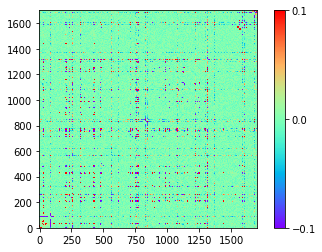

In [41]:
plt.imshow(w_pred_2d,cmap='rainbow',origin='lower')
plt.clim(-0.1,0.1)
plt.colorbar(fraction=0.045, pad=0.05,ticks=[-0.1,0,0.1])

In [47]:
np.savetxt('w2d.txt',w_pred_2d,fmt='%f')
np.savetxt('s0.txt',s0,fmt='%f')